In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil
from models.enums.chartType import TrainingCharts
import torch
from metrics.accuracy import get_accuracy
from metrics.modelAnalysisUtils import ModelAnalysisUtils
from models.modelAnalysis.multiRunAnalysis import MultiRunAnalysis
from matplotlib import pyplot as plt
import seaborn as sns
from models.enums.similarityType import AbsSimilarityType

In [3]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique=False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

In [4]:
def get_models_to_plot_from_combined(combined_charts):
    sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i]
    control_models = [ i for i in combined_charts.get_models() if "Control" in i]
    dense_models = [ i for i in combined_charts.get_models() if "Dense" in i]

    return sparse_models, control_models, dense_models

In [8]:
layers = 3
model_params_all = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (200, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 10), "l2": (200, 10), "l3": (200, None)}
model_params_first_third = {"l1": (200, 10), "l2": (200, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (200, 10), "l3": (200, 10)}

In [9]:
model_types = {"Complete Sparse model": model_params_all, 
               "1st L Sparse": model_params_first, 
               "2nd L Sparse": model_params_second,
               "3rd L Sparse": model_params_third,
               "1st and 2nd L Sparse": model_params_first_second,
               "1st and 3rd L Sparse": model_params_first_third,
               "2nd and 3rd L Sparse": model_params_second_third
            }

In [10]:
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [11]:
def get_models(modelTypes = model_types):
    sparseResults, trainActivations, testActivations = experiment.train_models(
        models = 
        {
            "Control Model": modelSetups._get_control_model,
            "Dense Model": modelSetups._get_dense_model,
        },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers,  
        model_params = model_types["Complete Sparse model"],
        n_epochs=150,
    )

    for modelName in model_types:
        newSparseResults, newTrainActivations, newTestActivations = experiment.train_models(
            models = {
                modelName: modelSetups._get_sparse_model,
                },
            in_features = in_features, 
            out_features = out_features, 
            layers = layers, 
            model_params = model_types[modelName],
            n_epochs = 150,
            )
        sparseResults = sparseResults | newSparseResults
        trainActivations = trainActivations | newTrainActivations
        testActivations = testActivations | newTestActivations
    return sparseResults, trainActivations, testActivations

In [31]:
multi_run_analysis = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()

In [ ]:
n_runs = 50
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models()
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_val, y_val)
            if accuracy != 1.:
                print(i, modelName, accuracy)
    multi_run_analysis.add_run_test_data_xor(sparseActivations)

5 Control Model 0.75
10 Control Model 0.75
17 Control Model 0.75
23 3rd L Sparse 0.75


In [42]:
multi_run_analysis.models[modelName].layers['out'].activation_values[0]

tensor([[32.7457, -1.1220],
        [ 6.5888, 22.1875],
        [-2.1257, 25.3840],
        [36.6330, -1.4690]])

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_74174/3111826405.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  filtered_flat = flat[np.abs(flat) > threshold]


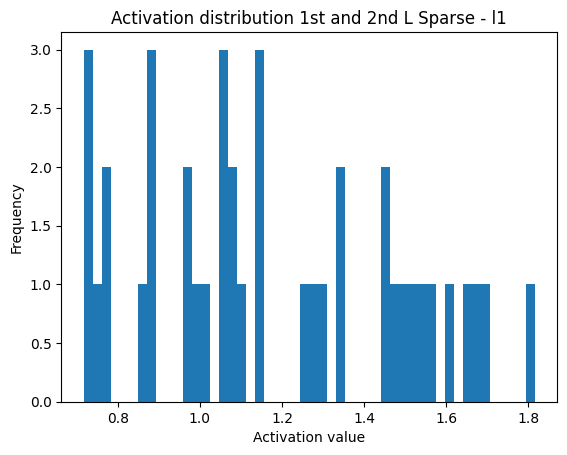

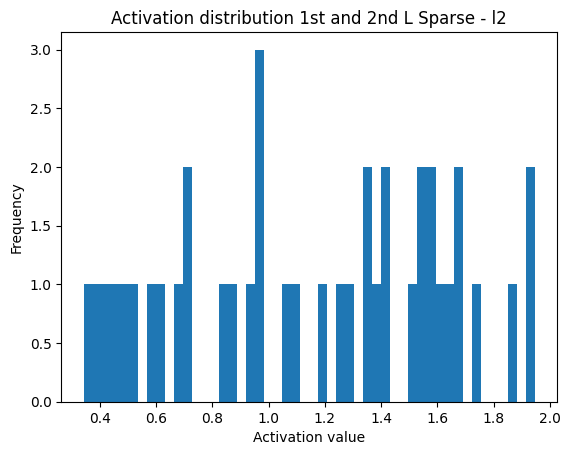

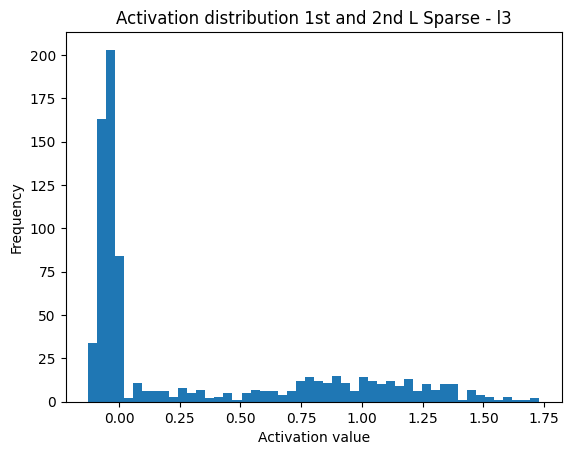

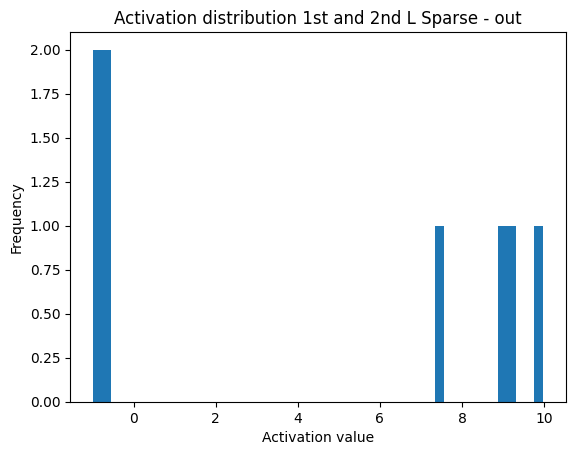

In [104]:
import numpy as np


run_number = 0
input_map = {
    "00": 0,
    "01": 1,
    "10": 2,
    "11": 3
}
layer_acts = {}
threshold = 1e-4
modelName = '1st and 2nd L Sparse'
# for input_value, input_index in input_map.items():
for layerName, layerAnalysis in multi_run_analysis.models[modelName].layers.items():
        # acts = layerAnalysis.activation_values[run_number][input_index]
        # flat = acts.flatten()
        # filtered_flat = flat[np.abs(flat) > threshold]
        # plt.hist(filtered_flat, bins=50)
        # plt.title(f'Activation distribution {modelName} - {layerName} - {input_value}')
        # plt.xlabel('Activation value')
        # plt.ylabel('Frequency')
        # plt.show()
    acts = layerAnalysis.activation_values[run_number]
    flat = acts.flatten()
    filtered_flat = flat[np.abs(flat) > threshold]
    plt.hist(filtered_flat, bins=50)
    plt.title(f'Activation distribution {modelName} - {layerName}')
    plt.xlabel('Activation value')
    plt.ylabel('Frequency')
    plt.show()

In [19]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [10]:
def get_models(experiment = experiment, model_types = model_types, needTrainActivations = False, batch_train = True, n_epochs = 150, lr = 0.01, seed = 0):
    sparseResults, trainActivations, testActivations = experiment.train_models(
        models = 
        {
            "Control Model": modelSetups._get_control_model,
            "Dense Model": modelSetups._get_dense_model,
        },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers,  
        model_params = model_types["Complete Sparse model"],
        n_epochs=n_epochs,
        batch_train=batch_train,
        return_train_acts = needTrainActivations,
        lr = lr,
        seed = seed
    )

    for modelName in model_types:
        newSparseResults, newTrainActivations, newTestActivations = experiment.train_models(
            models = {
                modelName: modelSetups._get_sparse_model,
                },
            in_features = in_features, 
            out_features = out_features, 
            layers = layers, 
            model_params = model_types[modelName],
            n_epochs = n_epochs,
            batch_train=batch_train,
            return_train_acts = needTrainActivations,
            lr = lr,
            seed = seed
            )
        sparseResults = sparseResults | newSparseResults
        trainActivations = trainActivations | newTrainActivations
        testActivations = testActivations | newTestActivations
    return sparseResults, trainActivations, testActivations

In [ ]:
multi_run_analysis_2d = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()

In [ ]:
n_runs = 60
for _ in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment, 
                                                                  model_types, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False)
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_train, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    multi_run_analysis_2d.add_run_test_data_xor(sparseActivations)
    multi_run_analysis_2d.add_run_train_data_xor(trainActivations)

Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75


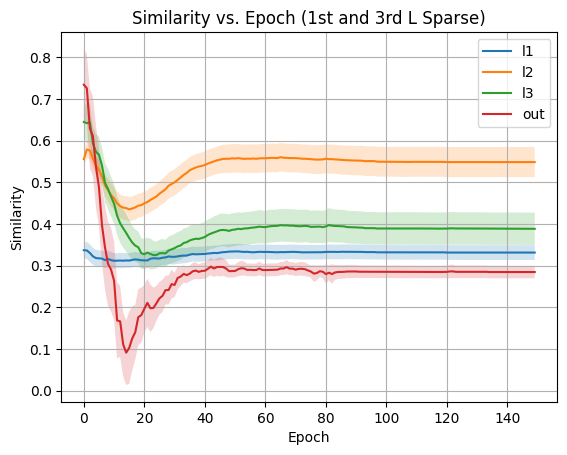

In [77]:
train_dfs = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_2d)
model_name = "1st and 3rd L Sparse"
for layer_name, (df_mean, df_ci) in train_dfs[model_name].items():
    # Extract data
    epochs = df_mean.index
    similarities = df_mean['similarity']
    ci = df_ci['ci']

    # Plot line for mean similarity
    plt.plot(epochs, similarities, label=f"{layer_name}")

    # Plot shaded region for 95% confidence interval
    plt.fill_between(
        epochs,
        similarities - ci,
        similarities + ci,
        alpha=0.2
    )

# Add labels, legend, etc.
plt.title(f"Similarity vs. Epoch ({model_name})")
plt.xlabel("Epoch")
plt.ylabel("Similarity")
plt.legend()
plt.grid(True)
plt.show()



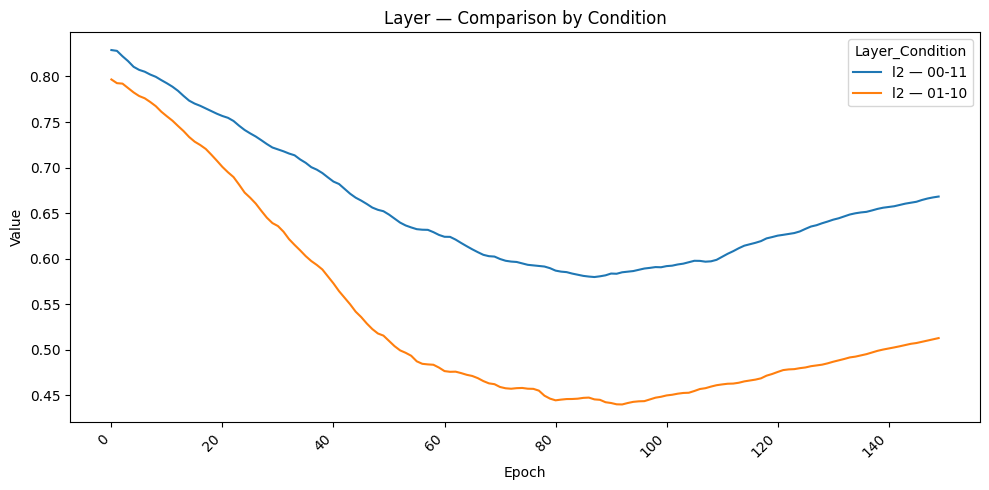

In [80]:
records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_2d, graphType=AbsSimilarityType.WITHIN)
records_2 = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_2d, graphType=AbsSimilarityType.BETWEEN)

plt.figure(figsize=(10, 5))
df_filtered = records[records["Model"] == "Control Model"]
df_filtered = df_filtered[df_filtered["Layer"] == "l2"]
df_filtered["Layer_Condition"] = df_filtered["Layer"] + " — " + df_filtered["Condition"]
sns.lineplot(data=df_filtered, x="Epoch", y="Value", hue="Layer_Condition", estimator='mean', errorbar=None)
plt.title(f"Layer — Comparison by Condition")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [56]:
import pandas as pd


combined_records = pd.concat([records, records_2], ignore_index=True)
combined_records

,Model,Layer,Condition,Value,Epoch
0,Control Model,l1,00-11,0.799892,0
1,Control Model,l1,01-10,0.923268,0
2,Control Model,l1,00-11,0.912013,0
3,Control Model,l1,01-10,0.682177,0
4,Control Model,l1,00-11,0.667757,0
...,...,...,...,...,...
1619995,2nd and 3rd L Sparse,out,11-10,-0.042904,149
1619996,2nd and 3rd L Sparse,out,00-01,0.179232,149
1619997,2nd and 3rd L Sparse,out,00-10,0.178401,149
1619998,2nd and 3rd L Sparse,out,11-01,0.178752,149


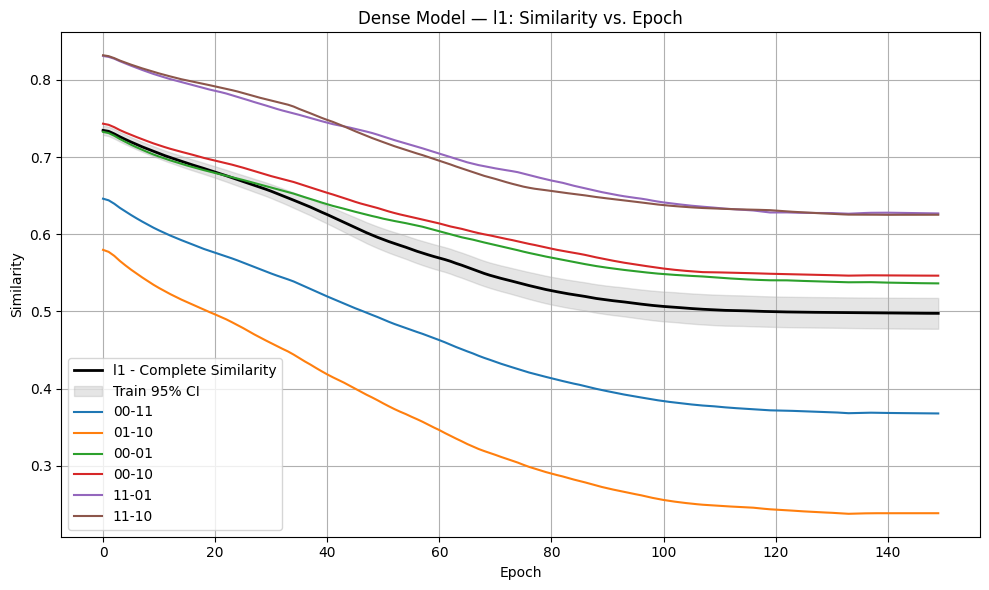

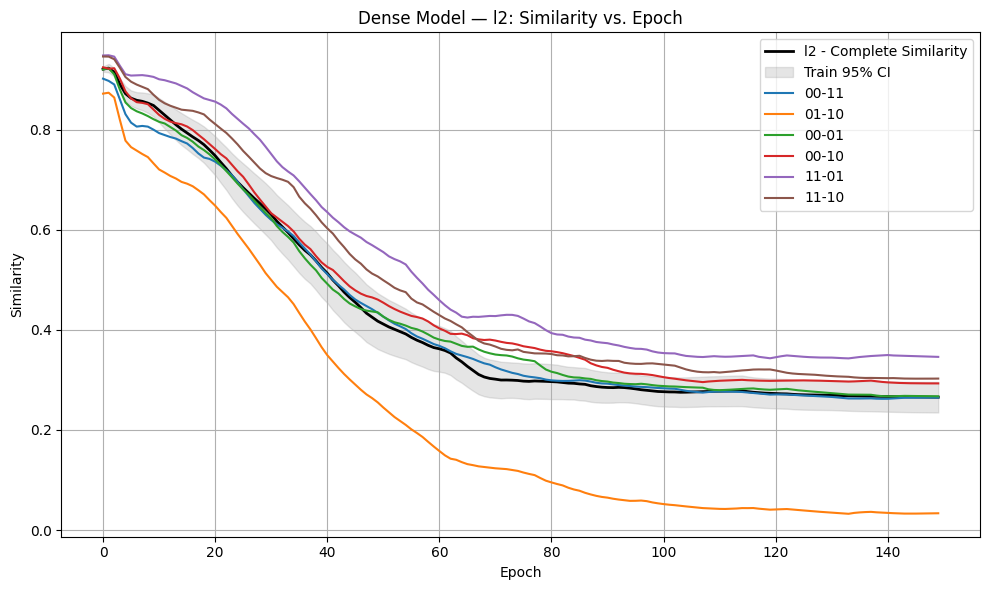

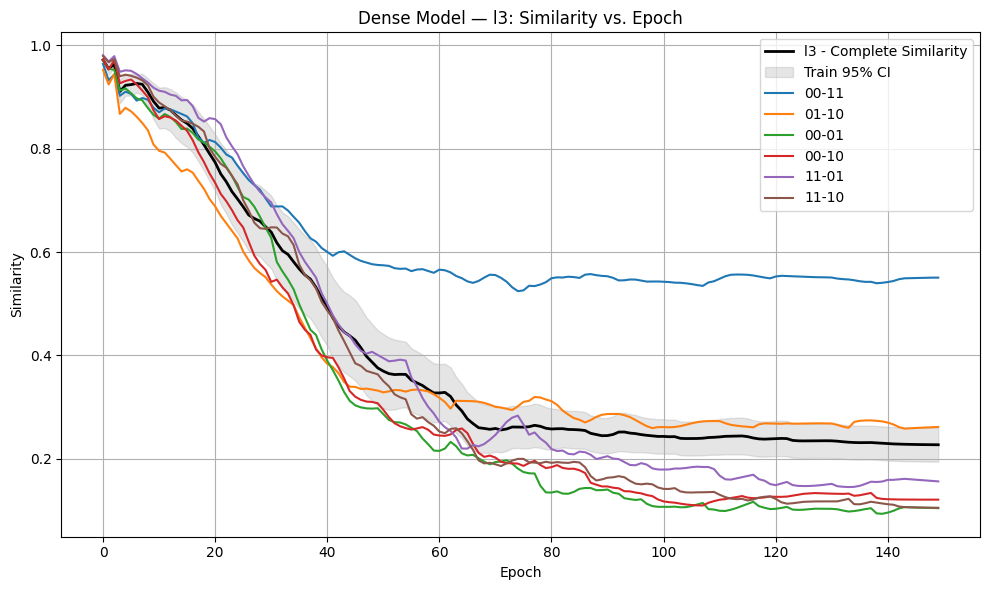

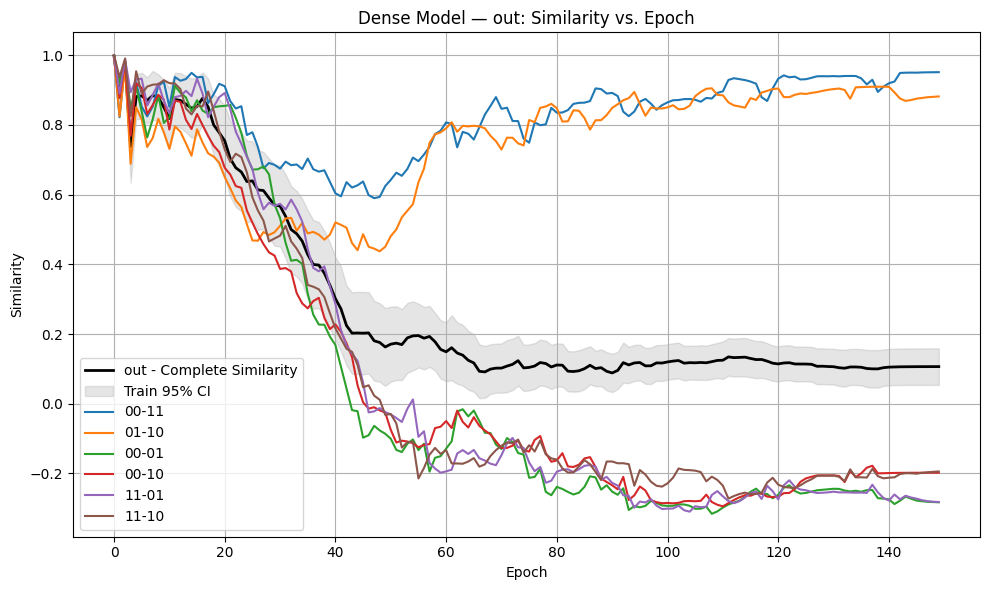

In [ ]:
model_to_plot = "Dense Model"

# Filter df for the chosen model
df_filtered = combined_records[combined_records["Model"] == model_to_plot]

# Loop through each layer of that model
for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
    plt.figure(figsize=(10, 6))
    epochs = df_mean.index
    mean_vals = df_mean["similarity"]
    ci_vals = df_ci["ci"]

    plt.plot(
        epochs, mean_vals, label=f"{layer_name} - Complete Similarity", color="black", linewidth=2
    )
    plt.fill_between(
        epochs,
        mean_vals - ci_vals,
        mean_vals + ci_vals,
        alpha=0.2,
        color="gray",
        label="Train 95% CI"
    )


    df_layer = df_filtered[df_filtered["Layer"] == layer_name]

    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=None,            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
    )

    # === Formatting ===
    plt.title(f"{model_to_plot} — {layer_name}: Similarity vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
dataset = XOR()
in_features = 8
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [ ]:
multi_run_analysis = MultiRunAnalysis()

In [ ]:
n_runs = 20
for _ in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment, model_types)
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_train, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    multi_run_analysis.add_run_test_data_xor(sparseActivations)

Control Model 0.970588207244873
Complete Sparse model 0.9754902124404907
1st and 2nd L Sparse 0.9754902124404907
1st and 3rd L Sparse 0.9901960492134094
Complete Sparse model 0.9852941036224365
1st and 2nd L Sparse 0.9656862616539001
1st and 3rd L Sparse 0.9852941036224365
Control Model 0.9313725233078003
Complete Sparse model 0.9852941036224365
1st L Sparse 0.9901960492134094
1st and 2nd L Sparse 0.9901960492134094
1st and 3rd L Sparse 0.9950980544090271
Control Model 0.8578431606292725
1st L Sparse 0.9803921580314636
1st and 2nd L Sparse 0.9803921580314636
1st and 3rd L Sparse 0.9950980544090271
2nd and 3rd L Sparse 0.9950980544090271
Control Model 0.9558823704719543
Complete Sparse model 0.9656862616539001
1st L Sparse 0.9803921580314636
1st and 2nd L Sparse 0.9803921580314636
1st and 3rd L Sparse 0.9950980544090271
Control Model 0.9558823704719543
Complete Sparse model 0.9950980544090271
1st L Sparse 0.9901960492134094
1st and 2nd L Sparse 0.970588207244873
1st and 3rd L Sparse 0.9

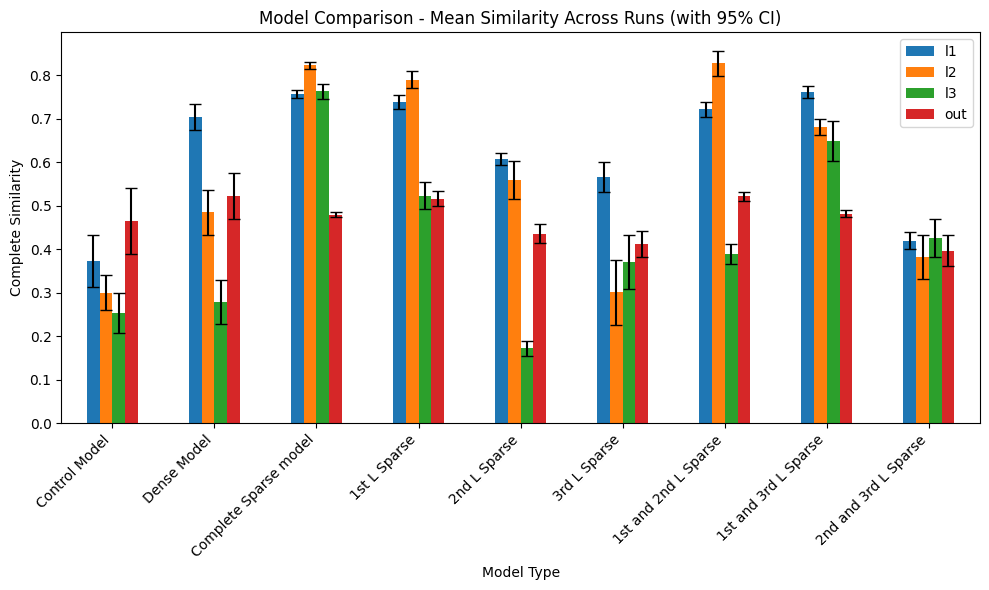

In [ ]:
df_mean, df_ci = modelAnalysisUtils.create_similarity_complete_df_multi_run(multi_run_analysis)
# df_mean, df_ci = modelAnalysisUtils.create_int_sep_df_multi_run(multi_run_analysis, needIntegration=False)

ax = df_mean.plot(kind='bar', yerr=df_ci, capsize=4, figsize=(10, 6))

plt.title("Model Comparison - Mean Similarity Across Runs (with 95% CI)")
plt.ylabel("Complete Similarity")
plt.xlabel("Model Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
layers = 2
model_params_all = {"l1": (200, 10), "l2": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10)}
model_types = {"Complete Sparse model": model_params_all, 
               "1st L Sparse": model_params_first, 
               "2nd L Sparse": model_params_second
            }

In [6]:
from datasets.dymmyProblem import DummyDataset


dataset = DummyDataset()
X_train, y_train, X_val, y_val = dataset.get_dataset(original_split= True, unique = True)
in_features = len(X_train[0])
out_features = 2
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [7]:
X_train, y_train

(tensor([[1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 1., 1., 1., 1., 0.],
         [1., 1., 0., 1., 0., 1., 0.],
         [1., 0., 1., 1., 1., 0., 0.],
         [0., 1., 1., 0., 1., 1., 0.],
         [1., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0.],
         [0., 1., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 0., 1.],
         [1., 1., 1., 1., 0., 1., 1.]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]))

In [8]:
multi_run_analysis_7d = MultiRunAnalysis()
multi_run_analysis_7d_test = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()

In [11]:
from utils.seedGenerator import generate_seeds


n_runs = 5
seeds = generate_seeds(0, n_runs)
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment, 
                                                                  model_types, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False,
                                                                  n_epochs = 250,
                                                                  lr = 0.005,
                                                                  seed = seeds[i])
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    multi_run_analysis_7d.add_run_test_data_dummy(sparseActivations, X_val, y_val)
    multi_run_analysis_7d.add_run_train_data_dummy(trainActivations, X_train, y_train)
    multi_run_analysis_7d_test.add_run_train_data_dummy(testActivations, X_val, y_val)

Control Model 0.8571428656578064
Control Model 0.9285714030265808
Control Model 0.7142857313156128
Control Model 0.8571428656578064


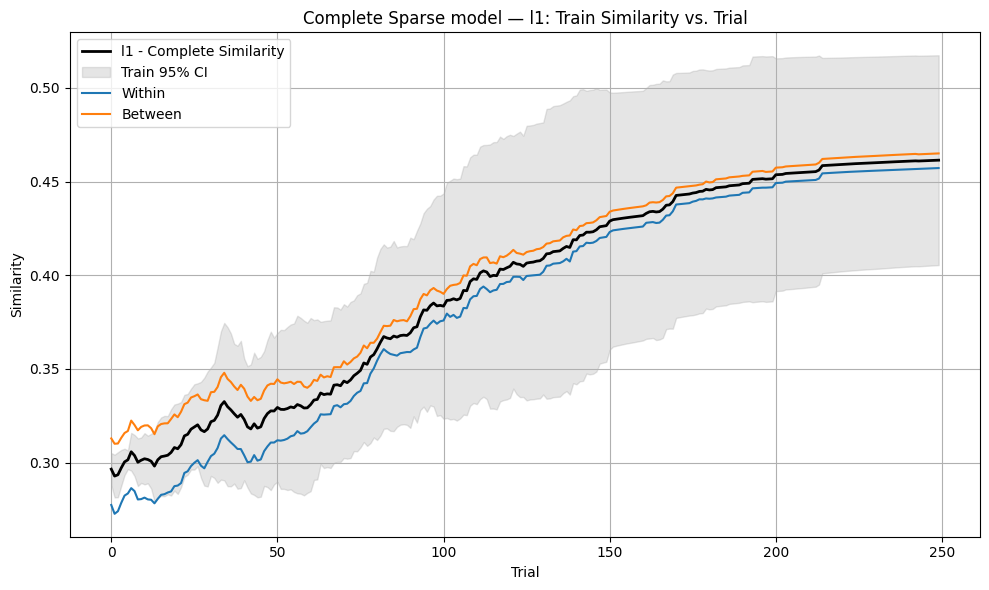

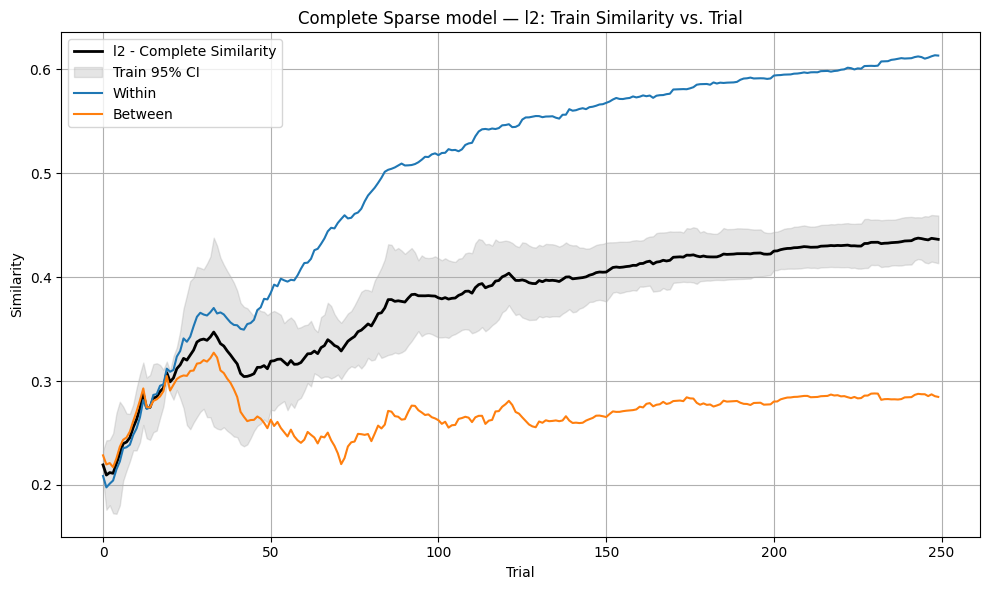

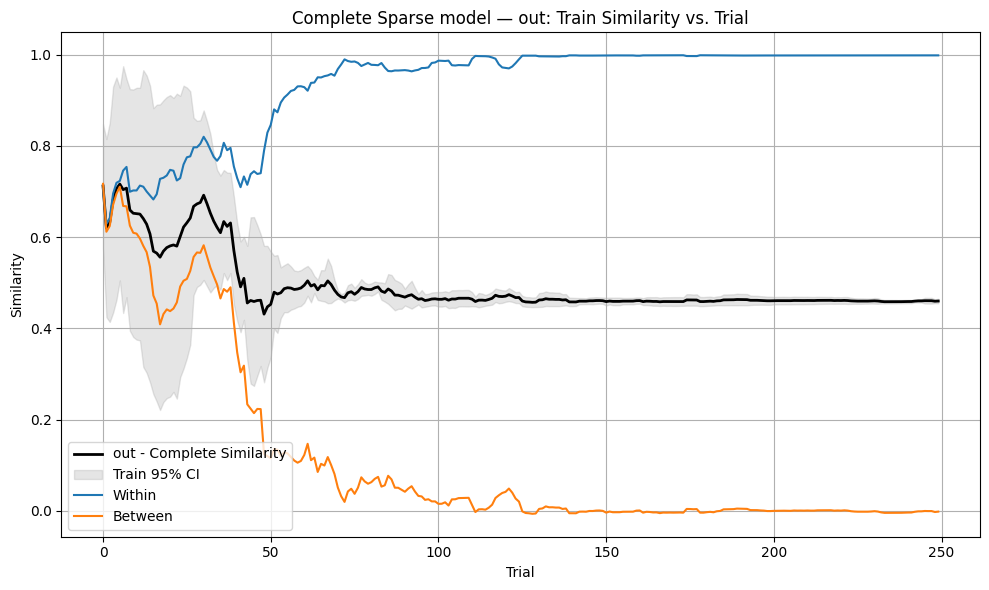

In [22]:
import pandas as pd

train_dfs = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_7d)
# within_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.WITHIN)
# btw_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.BETWEEN)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_7d, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_7d, needWithin=False)
combined_means = pd.concat([within_records, btw_records], ignore_index=True)
model_to_plot = "Complete Sparse model"
df_filtered = combined_means[combined_means["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
    plt.figure(figsize=(10, 6))
    epochs = df_mean.index
    mean_vals = df_mean["similarity"]
    ci_vals = df_ci["ci"]

    plt.plot(
        epochs, mean_vals, label=f"{layer_name} - Complete Similarity", color="black", linewidth=2
    )
    plt.fill_between(
        epochs,
        mean_vals - ci_vals,
        mean_vals + ci_vals,
        alpha=0.2,
        color="gray",
        label="Train 95% CI"
    )


    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=None,            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
    )

    # === Formatting ===
    plt.title(f"{model_to_plot} — {layer_name}: Train Similarity vs. Trial")
    plt.xlabel("Trial")
    plt.ylabel("Similarity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

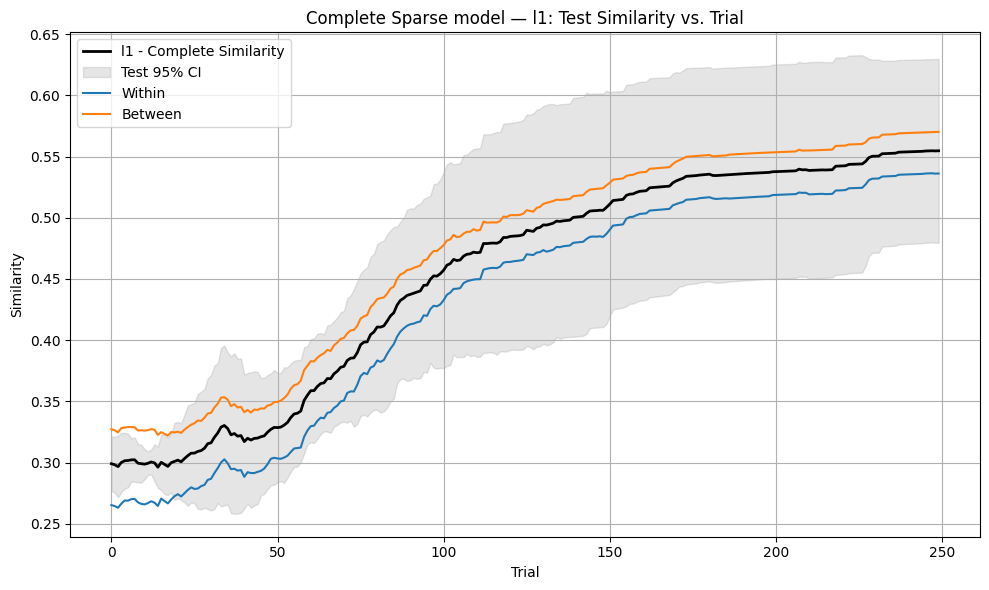

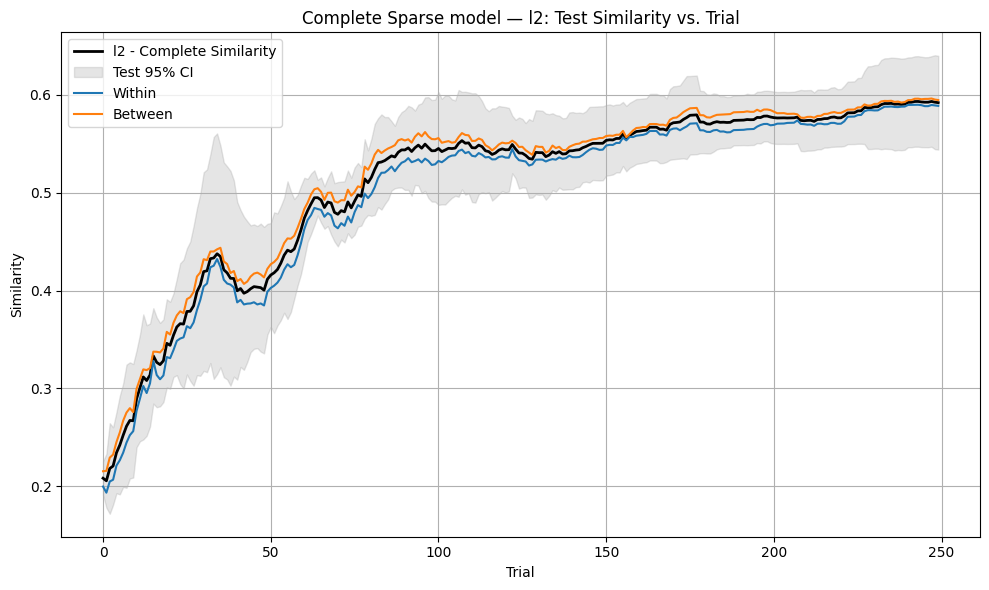

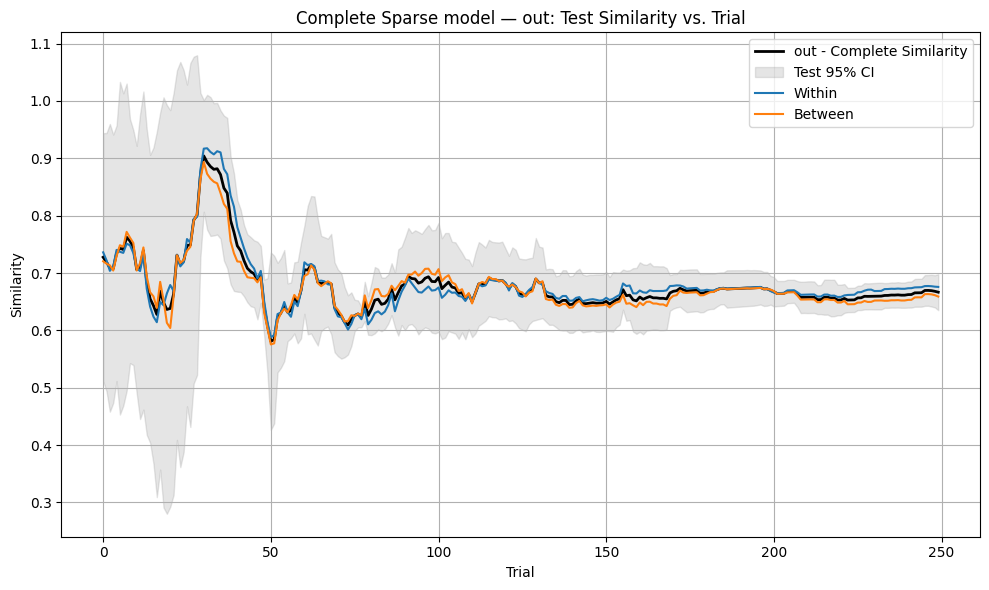

In [23]:
import pandas as pd

train_dfs = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_7d_test)
# within_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.WITHIN)
# btw_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.BETWEEN)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_7d_test, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_7d_test, needWithin=False)
combined_means = pd.concat([within_records, btw_records], ignore_index=True)
model_to_plot = "Complete Sparse model"
df_filtered = combined_means[combined_means["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
    plt.figure(figsize=(10, 6))
    epochs = df_mean.index
    mean_vals = df_mean["similarity"]
    ci_vals = df_ci["ci"]

    plt.plot(
        epochs, mean_vals, label=f"{layer_name} - Complete Similarity", color="black", linewidth=2
    )
    plt.fill_between(
        epochs,
        mean_vals - ci_vals,
        mean_vals + ci_vals,
        alpha=0.2,
        color="gray",
        label="Test 95% CI"
    )


    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=None,            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
    )

    # === Formatting ===
    plt.title(f"{model_to_plot} — {layer_name}: Test Similarity vs. Trial")
    plt.xlabel("Trial")
    plt.ylabel("Similarity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()